# 1. Import Necessary Libraries

Make sure  Microsoft Visual C++ is installed on your pc

Extracting text from pdf and converting to csv

In [1]:
"""
# PDF Text Extraction and Topic Modeling

This program extracts text from PDFs, cleans it, and performs topic modeling using BERTopic.

Process steps
1. Import necessary libraries
2. Extract text from either a single or multiple research study PDFs. Path is 'studies/papers'
3. Clean it using spaCy with language support for english, dutch and french.
4. Perform topic modeling using BERTopic
5. Visualize the topics

## Requirements
python -m spacy download fr_core_web_sm
python -m spacy download nl_core_web_md
python -m spacy download en_core_web_md
Use the following Python version 3.12.0 otherwise the code will not work due to spacy compatibility.
"""

"\n# PDF Text Extraction and Topic Modeling\n\nThis program extracts text from PDFs, cleans it, and performs topic modeling using BERTopic.\n\nProcess steps\n1. Import necessary libraries\n2. Extract text from either a single or multiple research study PDFs. Path is 'studies/papers'\n3. Clean it using spaCy with language support for english, dutch and french.\n4. Perform topic modeling using BERTopic\n5. Visualize the topics\n\n## Requirements\npython -m spacy download fr_core_web_sm\npython -m spacy download nl_core_web_md\npython -m spacy download en_core_web_md\nUse the following Python version 3.12.0 otherwise the code will not work due to spacy compatibility.\n"

In [ ]:
import csv
import logging
import os
import re
import json
from collections import Counter
from typing import List, Dict, Any
import numpy as np  # For numerical operations
from sklearn.feature_extraction.text import CountVectorizer  # For text vectorization
import pandas as pd  # For data manipulation
import spacy  # For language processing

from bertopic import BERTopic  # For topic modeling
import fitz # For PDF text extraction
from langdetect import detect, LangDetectException  # For language detection
from tqdm import tqdm  # For progress tracking
from wordsegment import load, segment  # For word segmentation
import matplotlib.pyplot as plt  # For visualization
import seaborn as sns  # For visualization

# 2. Extract text from either a single or multiple research study PDFs. Path is 'studies/papers'


In [3]:

# Load configuration from a JSON file
with open("config.json") as f:
    config = json.load(f)

PDF_DIRECTORY = config["pdf_directory"]  # Folder containing PDFs
CLEANED_CSV = config["cleaned_csv"]  # Cleaned CSV path
GDPR_CSV = config["gdpr_csv"]  # GDPR CSV path

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load spaCy models once to avoid repeated initialization
NLP_MODELS = {
    'en': spacy.load("en_core_web_lg"),
    'nl': spacy.load("nl_core_news_lg"),
    'fr': spacy.load("fr_core_news_lg"),
}

# Ligature replacement dictionary
LIGATURES = {
    'ﬁ': 'fi', 'ﬂ': 'fl', 'ﬃ': 'ffi', 'ﬄ': 'ffl', 'ﬀ': 'ff'
}

# Common word split fixes
COMMON_FIXES = {
    'signi ficant': 'significant', 'di fferent': 'different',
    'e ffective': 'effective', 'e ffect': 'effect',
    'chil dren': 'children', 'e ff ective': 'effective',
    'con fi dence': 'confidence'
}

# Unwanted keywords for filtering
UNWANTED_KEYWORDS = {
    'doi', 'https', 'http', 'journal', 'university', 'copyrighted',
    'taylor & francis', 'elsevier', 'published by', 'received',
    'revised', 'author(s)', 'source:', 'history:', 'keywords',
    'volume', 'downloaded', 'article', 'creative commons use',
    'authors', 'all rights reserved'
}

# Reference and Acknowledgement markers
REFERENCE_MARKERS = {'references', 'bibliography', 'acknowledgements', 'method', 'methods'}

def validate_pdf_path(pdf_path: str) -> bool:
    """Checks if the PDF file exists and is readable."""
    if not os.path.exists(pdf_path) or not os.access(pdf_path, os.R_OK):
        logging.error(f"PDF file is not accessible: {pdf_path}")
        return False
    return True

def is_heading(line: str) -> bool:
    """Determines if a line is a heading (all uppercase or starts with 'CHAPTER')."""
    return line.isupper() or line.startswith('CHAPTER')

def is_footnote(line: str) -> bool:
    """Identifies footnotes based on common patterns."""
    return bool(re.match(r'^\[\d+\]', line) or re.match(r'^\d+\.', line) or 
                line.startswith(('*', 'Note', 'Table')))

def contains_doi_or_https(line: str) -> bool:
    """Checks if a line contains unwanted keywords, DOIs, or URLs."""
    return any(keyword in line.lower() for keyword in UNWANTED_KEYWORDS)

def is_reference_or_acknowledgements_section(line: str) -> bool:
    """Checks if a line marks the start of references or acknowledgements."""
    return any(marker in line.lower() for marker in REFERENCE_MARKERS)

def replace_ligatures(text: str) -> str:
    """Replaces ligatures in text with their normal character equivalents."""
    for lig, replacement in LIGATURES.items():
        text = text.replace(lig, replacement)
    return text

def fix_common_word_splits(text: str) -> str:
    """Fixes common word splits in text."""
    for split_word, correct_word in COMMON_FIXES.items():
        text = text.replace(split_word, correct_word)
    return text

def detect_language(text: str) -> str:
    """Detects the language of a given text block."""
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

def process_pdf(file_path: str, filename: str) -> list:
    """Processes a single PDF file and extracts structured text data."""
    data = []
    title = os.path.splitext(filename)[0]  # Extract filename without extension
    
    try:
        with fitz.open(file_path) as pdf_document:
            section_reached = False  # Stop processing once references start

            for page_num in range(pdf_document.page_count):
                if section_reached:
                    break  # Stop processing once references detected

                page = pdf_document.load_page(page_num)
                text_dict = page.get_text("dict")  # Extract text while keeping layout

                for block in text_dict["blocks"]:
                    if block["type"] != 0:  # Ignore non-text blocks
                        continue

                    paragraph = []
                    prev_x = None  # Track x-coordinate for paragraph grouping

                    for line in block["lines"]:
                        line_text = " ".join(span["text"].replace(';', ',') for span in line["spans"])
                        line_text = replace_ligatures(line_text)
                        line_text = fix_common_word_splits(line_text)

                        if is_reference_or_acknowledgements_section(line_text):
                            section_reached = True
                            break  # Stop further processing

                        if (is_heading(line_text) or is_footnote(line_text) or 
                            contains_doi_or_https(line_text) or 
                            line_text.strip().lower() == title.lower()):
                            continue

                        first_word_x = line["spans"][0]["bbox"][0]

                        if prev_x is None or abs(first_word_x - prev_x) < 10:
                            paragraph.append(line_text)
                        else:
                            if paragraph:  # Store completed paragraph
                                full_text = " ".join(paragraph).strip()
                                if len(full_text.split()) >= 10:
                                    language = detect_language(full_text)
                                    data.append([filename, page_num + 1, full_text, language])
                            paragraph = [line_text]  # Start new paragraph

                        prev_x = first_word_x  # Update for next iteration

                    if paragraph and not section_reached:
                        full_text = " ".join(paragraph).strip()
                        if len(full_text.split()) >= 10:
                            language = detect_language(full_text)
                            data.append([filename, page_num + 1, full_text, language])

    except Exception as e:
        logging.error(f"Failed to process {file_path}: {e}")

    return data


all_data = []

pdf_files = [f for f in os.listdir(PDF_DIRECTORY) if f.endswith('.pdf')]

for filename in tqdm(pdf_files, desc="Processing PDFs"):
    file_path = os.path.join(PDF_DIRECTORY, filename)
    if validate_pdf_path(file_path):
        all_data.extend(process_pdf(file_path, filename))

if all_data:
    df_extracted = pd.DataFrame(all_data, columns=["File", "Page", "Text", "Language"])
    df_extracted.to_csv(CLEANED_CSV, index=False) 
    logging.info(f"Data successfully exported to {CLEANED_CSV}")


Processing PDFs: 100%|██████████| 30/30 [00:04<00:00,  6.77it/s]
2025-03-01 00:06:03,394 - INFO - Data successfully exported to csv/cleaned/cleanedpdfsV5.csv


In [4]:
# Load the data
df_cleaned = pd.read_csv(CLEANED_CSV)
df_cleaned.head(30)

,File,Page,Text,Language
0,Advantages of mixed-age free play in elementar...,1,Full Terms & Conditions of access and use can ...,en
1,Advantages of mixed-age free play in elementar...,1,Advantages of mixed-age free play in elementar...,en
2,Advantages of mixed-age free play in elementar...,1,mixed-age free play in elementary school: perc...,en
3,Advantages of mixed-age free play in elementar...,2,Advantages of mixed-age free play in elementar...,en
4,Advantages of mixed-age free play in elementar...,2,Mixed-age groups have been shown to be effecti...,en
5,Advantages of mixed-age free play in elementar...,2,expressed their support for cross-age interact...,en
6,Advantages of mixed-age free play in elementar...,2,"Most of us, and even most of our parents and g...",en
7,Advantages of mixed-age free play in elementar...,2,Children need to cultivate a diverse set of sk...,en
8,Advantages of mixed-age free play in elementar...,2,"( 2015 ), increased standardization runs count...",en
9,Advantages of mixed-age free play in elementar...,3,"the 6 C ’ s – collaboration, communication, ...",en


# 3. Clean it using spaCy with language support for english, dutch and french.
We clean up the text
- Remove the name of city, country, geography for better outcome
- Remove special characters (only letters)
- Convert to lower case
- Remove stop words
- Remove words of only one or 2 letters ('a', 'I', at,...)
- Remove very short sentences
- Remove urls 
- use stemming
- remove duplicate sentences

In [5]:

# Define entity types to remove (Personal Information)
PERSONAL_ENTITIES = {"PERSON", "EMAIL", "PHONE", "GPE", "ORG", "NORP", "FAC", "LOC", "PRODUCT", "EVENT", "WORK_OF_ART", "LAW"}

def remove_personal_info(text: str, lang: str) -> str:
    """Uses spaCy NER to remove personal information based on language."""
    if lang not in NLP_MODELS:
        return text  # Skip processing if language model is not available

    nlp = NLP_MODELS[lang]  # Select the correct model
    doc = nlp(text)

    # Replace personal entities with [REDACTED]
    for ent in doc.ents:
        if ent.label_ in PERSONAL_ENTITIES:
            text = text.replace(ent.text, "[REDACTED]")
            
        if ent.label_ == "DATE" and len(ent.text):
            text = text.replace(ent.text, "")  # Remove dates

    # Remove emails and phone numbers using regex (fallback)
    text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "[REDACTED]", text)  # Email
    text = re.sub(r"\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b", "[REDACTED]", text)  # Phone Numbers

    return text

def anonymize_csv(input_csv: str, output_csv: str):
    """Reads a CSV file, anonymizes text based on language, and write to a new CSV."""
    try:
        df = pd.read_csv(input_csv)

        # Apply anonymization function to text column with respective language
        df["Text"] = df.apply(lambda row: remove_personal_info(str(row["Text"]), row["Language"]), axis=1)

        # Write anonymized data to csv
        df.to_csv(output_csv, index=False)
        logging.info(f"Anonymized data saved to {output_csv}")

    except Exception as e:
        logging.error(f"Error processing file: {e}")

# Run the anonymization process 
anonymize_csv(CLEANED_CSV, GDPR_CSV)


2025-03-01 00:06:13,426 - INFO - Anonymized data saved to csv/gdpr/gdprcompliantV5.csv


In [6]:
df_cleaned = pd.read_csv(GDPR_CSV)
df_cleaned.head(30)

,File,Page,Text,Language
0,Advantages of mixed-age free play in elementar...,1,Full Terms & Conditions of access and use can ...,en
1,Advantages of mixed-age free play in elementar...,1,Advantages of mixed-age free play in elementar...,en
2,Advantages of mixed-age free play in elementar...,1,mixed-age free play in elementary school: perc...,en
3,Advantages of mixed-age free play in elementar...,2,Advantages of mixed-age free play in elementar...,en
4,Advantages of mixed-age free play in elementar...,2,Mixed-age groups have been shown to be effecti...,en
5,Advantages of mixed-age free play in elementar...,2,expressed their support for cross-age interact...,en
6,Advantages of mixed-age free play in elementar...,2,"Most of us, and even most of our parents and g...",en
7,Advantages of mixed-age free play in elementar...,2,Children need to cultivate a diverse set of sk...,en
8,Advantages of mixed-age free play in elementar...,2,"( ), increased standardization runs counter t...",en
9,Advantages of mixed-age free play in elementar...,3,"the 6 C ’ s – collaboration, communication, ...",en


In [7]:
df_gdpr = pd.read_csv(GDPR_CSV)
df_gdpr.head(30)

,File,Page,Text,Language
0,Advantages of mixed-age free play in elementar...,1,Full Terms & Conditions of access and use can ...,en
1,Advantages of mixed-age free play in elementar...,1,Advantages of mixed-age free play in elementar...,en
2,Advantages of mixed-age free play in elementar...,1,mixed-age free play in elementary school: perc...,en
3,Advantages of mixed-age free play in elementar...,2,Advantages of mixed-age free play in elementar...,en
4,Advantages of mixed-age free play in elementar...,2,Mixed-age groups have been shown to be effecti...,en
5,Advantages of mixed-age free play in elementar...,2,expressed their support for cross-age interact...,en
6,Advantages of mixed-age free play in elementar...,2,"Most of us, and even most of our parents and g...",en
7,Advantages of mixed-age free play in elementar...,2,Children need to cultivate a diverse set of sk...,en
8,Advantages of mixed-age free play in elementar...,2,"( ), increased standardization runs counter t...",en
9,Advantages of mixed-age free play in elementar...,3,"the 6 C ’ s – collaboration, communication, ...",en


## Using SpaCy NER to make the Model GDPR Compliant
- Remove any sensitive data and patterns, The GDPR data will be saved in a new csv file.

In [8]:
# Map languages to their respective spaCy models and stop words
LANGUAGE_MODELS = {
    'en': (NLP_MODELS['en'], EN_STOP_WORDS),
    'nl': (NLP_MODELS['nl'], NL_STOP_WORDS),
    'fr': (NLP_MODELS['fr'], FR_STOP_WORDS)
}

# Function to clean text using spaCy
def spaCyclean_text(text, language):
    if language not in LANGUAGE_MODELS:
        return text  # Return the original text if the language is not supported

    nlp, stop_words = LANGUAGE_MODELS[language]
    doc = nlp(text)

    # Lemmatize, remove stop words, and filter out short tokens
    cleaned_tokens = [
        token.lemma_.lower() for token in doc
        if not token.is_stop  # Remove stop words
        and not token.is_punct  # Remove punctuation
        and not token.is_space  # Remove spaces
        and len(token.text) > 3  # Remove short tokens
    ]
    return " ".join(cleaned_tokens)

# Clean the text in the DataFrame
df_gdpr["GDPR_Text"] = df_gdpr.apply(
    lambda row: spaCyclean_text(row["Text"], row["Language"]), 
    axis=1
)

# Drop the original "Text" column
if "Text" in df_gdpr:
    df_gdpr.drop(columns=["Text"], inplace=True)

# Save the cleaned DataFrame to a new CSV file
df_gdpr.to_csv(GDPR_CSV, index=False)
print(f"Cleaned data saved to {GDPR_CSV}")
df_gdpr.head(30)

Cleaned data saved to csv/gdpr/gdprcompliantV5.csv


,File,Page,Language,GDPR_Text
0,Advantages of mixed-age free play in elementar...,1,en,terms conditions access find
1,Advantages of mixed-age free play in elementar...,1,en,advantage mixed free play elementary school pe...
2,Advantages of mixed-age free play in elementar...,1,en,mixed free play elementary school perception s...
3,Advantages of mixed-age free play in elementar...,2,en,advantage mixed free play elementary school pe...
4,Advantages of mixed-age free play in elementar...,2,en,mixed group show effective classroom setting h...
5,Advantages of mixed-age free play in elementar...,2,en,express support cross interaction mixed groupi...
6,Advantages of mixed-age free play in elementar...,2,en,parent grandparent grow segregate school syste...
7,Advantages of mixed-age free play in elementar...,2,en,child need cultivate diverse skill point redact
8,Advantages of mixed-age free play in elementar...,2,en,increase standardization run counter child lea...
9,Advantages of mixed-age free play in elementar...,3,en,collaboration communication critical thinking ...



# 4. Initialize and fit BERTopic
The good thing with BERTopic is that is does most of the work automatically (Meaning, I do not need to bore you to death with details about how it works behind te scenes.)

We need to do 3 things
1. Initialize BERTopic model
2. 'Fit' the model -> this  means: run the model, as you would run a simple linear regression
3. Look at the topics via 

To get started, let's just use the default settings.

In [19]:
# Initialize BERTopic model
topic_model = BERTopic(calculate_probabilities=True)

# Fit the model on the cleaned text data
topics, probabilities = topic_model.fit_transform(df_gdpr["GDPR_Text"])

# Get the topics
topics_overview = topic_model.get_topic_info()
print(topics_overview)


2025-03-01 00:38:22,154 - INFO - Use pytorch device_name: cpu
2025-03-01 00:38:22,155 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


   Topic  Count                                       Name  \
0     -1     25           -1_moral_terms_conditions_access   
1      0    470          0_child_classroom_redact_redacted   
2      1     63  1_literacy_environment_physical_classroom   
3      2     60              2_care_caregiver_child_redact   
4      3     50               3_redact_redacted_mail_thank   

                                      Representation  \
0  [moral, terms, conditions, access, find, child...   
1  [child, classroom, redact, redacted, mixed, pe...   
2  [literacy, environment, physical, classroom, r...   
3  [care, caregiver, child, redact, quality, grou...   
4  [redact, redacted, mail, thank, information, a...   

                                 Representative_Docs  
0  [terms conditions access find, terms condition...  
1  [relate classroom composition academic redact ...  
2  [show shape classroom environment numerous way...  
3  [peer group composition context early educatio...  
4  [redacted re

# 5. Visualize Topics
- Visualize Topic Hierarchy
- Visualize documents
- Visualize topics full article

In [20]:
# Visualize topics with an interactive plot
topic_model.visualize_topics()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([[0, 'child | classroom | redact | redacted | mixed', 470],
                                   [1, 'literacy | environment | physical | classroom | redact', 63],
                                   [2, 'care | caregiver | child | redact | quality', 60],
                                   [3, 'redact | redacted | mail | thank | information', 50]], dtype=object),
              'hovertemplate': '<b>Topic %{customdata[0]}</b><br>%{customdata[1]}<br>Size: %{customdata[2]}',
              'legendgroup': '',
              'marker': {'color': '#B0BEC5',
                         'line': {'color': 'DarkSlateGrey', 'width': 2},
                         'size': {'bdata': '1gE/ADwAMgA=', 'dtype': 'i2'},
                         'sizemode': 'area',
                         'sizeref': 0.29375,
                         'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': {'bdata': '/nDaP5ygWD+X9wZA1K31Pw==', 'dtype': 'f4'},
              'xaxis': 'x',
              'y': {'bdata': 'We2zQGaPrkBHx59A6VjMQA==', 'dtype': 'f4'},
              'yaxis': 'y'}],
    'layout': {'annotations': [{'showarrow': False,
                                'text': 'D1',
                                'x': 0.7192705988883972,
                                'y': 5.793922877311706,
                                'yshift': 10},
                               {'showarrow': False,
                                'text': 'D2',
                                'x': 1.5722307682037355,
                                'xshift': 10,
                                'y': 7.3437312841415405}],
               'height': 650,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'legend': {'itemsizing': 'constant', 'tracegroupgap': 0},
               'margin': {'t': 60},
               'shapes': [{'line': {'color': '#CFD8DC', 'width': 2},
                           'type': 'line',
                           'x0': 1.5722307682037355,
                           'x1': 1.5722307682037355,
                           'y0': 4.244114470481873,
                           'y1': 7.3437312841415405},
                          {'line': {'color': '#9E9E9E', 'width': 2},
                           'type': 'line',
                           'x0': 0.7192705988883972,
                           'x1': 2.4251909375190737,
                           'y0': 5.793922877311706,
                           'y1': 5.793922877311706}],
               'sliders': [{'active': 0,
                            'pad': {'t': 50},
                            'steps': [{'args': [{'marker.color': [['red', '#B0BEC5', '#B0BEC5', '#B0BEC5']]}],
                                       'label': 'Topic 0',
                                       'method': 'update'},
                                      {'args': [{'marker.color': [['#B0BEC5', 'red', '#B0BEC5', '#B0BEC5']]}],
                                       'label': 'Topic 1',
                                       'method': 'update'},
                                      {'args': [{'marker.color': [['#B0BEC5', '#B0BEC5', 'red', '#B0BEC5']]}],
                                       'label': 'Topic 2',
                                       'method': 'update'},
                                      {'args': [{'marker.color': [['#B0BEC5', '#B0BEC5', '#B0BEC5', 'red']]}],
                                       'label': 'Topic 3',
                                       'method': 'update'}]}],
               'template': '...',
               'title': {'font': {'color': 'Black', 'size': 22},
                         'text': '<b>Intertopic Distance Map</b>',
                         'x': 0.5,
                         'xanchor': 'center',
                         'y': 0.95,
                         'yanchor': 'top'},
               'widt

In [21]:
topic_model.visualize_barchart()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.053251384512362485, 0.05670035968623318,
                    0.07376715511622696, 0.07759650592643379, 0.08630584974517452],
              'xaxis': 'x',
              'y': [mixed  , redacted  , redact  , classroom  , child  ],
              'yaxis': 'y'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.07019830781285255, 0.08068151938242756, 0.08267519023417305,
                    0.08715737903946785, 0.1991808282948861],
              'xaxis': 'x2',
              'y': [redact  , classroom  , physical  , environment  , literacy  ],
              'yaxis': 'y2'},
             {'marker': {'color': '#CC79A7'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.09835721182897894, 0.10149349250333659, 0.1057322551641539,
                    0.12317009535077157, 0.13775453139469115],
              'xaxis': 'x3',
              'y': [quality  , redact  , child  , caregiver  , care  ],
              'yaxis': 'y3'},
             {'marker': {'color': '#E69F00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.050187153176598366, 0.058284304540606444,
                    0.058284304540606444, 0.31246823507122856, 0.3642042086775949],
              'xaxis': 'x4',
              'y': [information  , thank  , mail  , redacted  , redact  ],
              'yaxis': 'y4'}],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 0',
                                'x': 0.0875,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 1',
                                'x': 0.36250000000000004,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 2',
                                'x': 0.6375000000000001,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 3',
                                'x': 0.9125,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'}],
               'height': 325.0,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'showlegend': False,
               'template': '...',
               'title': {'font': {'color': 'Black', 'size': 22},
                         'text': 'Topic Word Scores',
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
               'width': 1000,
               'xaxis': {'anchor': 'y', 'domain': [0.0, 0.175], 'showgrid': True},
               'xaxis2': {'anchor': 'y2', 'domain': [0.

# Visual Topic Hierarchy

In [23]:
hierarchical_topics = topic_model.hierarchical_topics(df_gdpr['GDPR_Text'])
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)


100%|██████████| 3/3 [00:00<00:00, 480.10it/s]


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'text': [child_classroom_redact_redacted_mixed, , ,
                       literacy_environment_physical_classroom_redact],
              'type': 'scatter',
              'x': {'bdata': 'AAAAAAAAAAAOIo7hH1HdPw4ijuEfUd0/AAAAAAAAAAA=', 'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': 'AAAAAAAAOcAAAAAAAAA5wAAAAAAAgEHAAAAAAACAQcA=', 'dtype': 'f8'},
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'text': [care_caregiver_child_redact_quality, , ,
                       child_classroom_redact_redacted_mixed],
              'type': 'scatter',
              'x': {'bdata': 'AAAAAAAAAACNHWWvSRPlP40dZa9JE+U/DiKO4R9R3T8=', 'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': 'AAAAAAAALsAAAAAAAAAuwAAAAAAAAD7AAAAAAAAAPsA=', 'dtype': 'f8'},
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'text': [redact_redacted_mail_thank_information, , ,
                       child_redact_classroom_redacted_mixed],
              'type': 'scatter',
              'x': {'bdata': 'AAAAAAAAAADMqjKGVQHoP8yqMoZVAeg/jR1lr0kT5T8=', 'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': 'AAAAAAAAFMAAAAAAAAAUwAAAAAAAgDbAAAAAAACANsA=', 'dtype': 'f8'},
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'hovertext': [],
              'marker': {'color': 'black'},
              'mode': 'markers',
              'showlegend': False,
              'type': 'scatter',
              'x': [],
              'y': []},
             {'hoverinfo': 'text',
              'hovertext': [child_classroom_redact_redacted_mixed,
                            child_redact_classroom_redacted_mixed],
              'marker': {'color': 'black'},
              'mode': 'markers',
              'showlegend': False,
              'type': 'scatter',
              'x': [0.4580764486968584, 0.6586044717486615],
              'y': [-30.0, -22.5]}],
    'layout': {'autosize': False,
               'height': 260,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'hovermode': 'closest',
               'plot_bgcolor': '#ECEFF1',
               'showlegend': False,
               'template': '...',
               'title': {'font': {'color': 'Black', 'size': 22},
                         'text': '<b>Hierarchical Clustering</b>',
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
               'width': 1000,
               'xaxis': {'mirror': 'allticks',
                         'rangemode': 'tozero',
                         'showgrid': False,
                         'showline': True,
                         'showticklabels': True,
                         'ticks': 'outside',
                         'type': 'linear',
                         'zeroline': False},
               'yaxis': {'mirror': 'allticks',
                         'range': [-40.0, 0.0],
                         'rangemode': 'tozero',
                         'showgrid': False,
                         'showline': True,
                         'showticklabels': True,
                         'tickmode': 'array',
                         'ticks': 'outside',
                         'ticktext': [3_redact_redacted_mail,
                                      2_care_caregiver_child,
                                      0_child_classroom_redact,
                                      1_literacy_environment_phys...],
                         'tickvals': [-5.0, -15.0, -25.0, -35.0],
                         'type': 'linear',
                         'zeroline': F

In [24]:
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

.
├─■──redact_redacted_mail_thank_information ── Topic: 3
└─child_redact_classroom_redacted_mixed
     ├─■──care_caregiver_child_redact_quality ── Topic: 2
     └─child_classroom_redact_redacted_mixed
          ├─■──child_classroom_redact_redacted_mixed ── Topic: 0
          └─■──literacy_environment_physical_classroom_redact ── Topic: 1



# Visualize documents

In [26]:
topic_model.visualize_documents(df_gdpr['GDPR_Text'])

Batches: 100%|██████████| 21/21 [00:02<00:00,  9.48it/s]


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hoverinfo': 'text',
              'hovertext': array(['terms conditions access find',
                                  'primary question ofthis present study moral behavior under- standing display preschool aged sib- ling interact young sibling home see interaction mixed age child care center',
                                  'terms conditions access find',
                                  'student work small multi group change relation number old child participate group',
                                  'ence home- center care pre- school child understanding moral social transgression find home- care child likely under- stand recognize moral transgression social transgression child attend center care redacted',
                                  'searcher hypothesize preschool child nurture help young peer prosoc behavior include moral behavior positively late attend child development ori- ente mixed child care center',
                                  'child moral development conduct environment e.g. redact nucci,1987 research investigate effect mixed grouping child moral behavior example research find preschooler attend program mixed grouping display coopera-',
                                  'stigat wheth preschool childr moral help behav- ior relate young peer direct ernal state languag talk young peer redact want redact perspective take skill attendance child developm orient mixed child care center redacted enty- pair child old peer youngerpeer otape whil play toy puzzl pre ente singly result indicat moral help behavior positively significan relate frequency vocal turn young peer perspective- abilit length redacted mixed center datum support developmental notion perspectiv take ability relate mixed group settin facilitate young child demonstration understanding ect moral development help behavior perspectiv take ability',
                                  'student learn interact teacher interest educational researcher practitioner highly evaluate goal redact social skill individual allow participate learn activity small group learn redact redacted suggest child knowledge idea develop interaction view social interaction capable peer play role under- stand meaning concept learning achieve student need learning environment promote interactive learning process preferably low grade education redact heart view learn situation context learning take place take consideration',
                                  'Arya Ansari a , ⁎ , Kelly M. Purtell b',
                                  'Natalia M. Rojas   a , * , Rachel M. Abenavoli   b',
                                  'reproduction distribution work permission provide original work attribute specify sage',
                                  'terms conditions access find',
                                  'Linda  E.  Derscheid N orthern  Illinois  Univ er sit y',
                                  'hypothesize preschool child moral behavior attend mixed center care relate preschool child understanding',
                                  'child participate mixed group likely child attend group classroom need investigate mixed group preschool child moral behav- understanding',
                                  'terms conditions access find',
                                  'permit unrestricted distribution reproduction medium provide original work properly cite term',
                                  'terms conditions access find', 'terms conditions access find',
                                  'terms conditions access find', 'terms conditions access find',
                                  'benefit especially area socioemotionaldevelopment includingmoral prosocial development involve coopera- tion nurture help behavior',
                                  'Elles J. de Schipper   a , J. Marianne Riksen-Walraven   a , ∗ , Sabine A.E. Geurts   b',
                                  'terms conditions access find', None], dtype=object),
             

In [29]:
# Add topics and probabilities to the original DataFrame
df_gdpr["topic_number"] = np.argmax(probabilities, axis=1)

# Also extract the topic names and assign them to the DataFrame
info = topic_model.get_topic_info()
topic_names = info['Representation']

df_gdpr['topic_name'] = df_gdpr['topic_number'].map(topic_names)

# Save the updated DataFrame to a CSV

df_gdpr['topic_name'] = df_gdpr['topic_number'].map(topic_names)

# Save to a new CSV file
df_gdpr.to_csv("studies_lobke_with_topics.csv", index=False)


In [30]:
df_gdpr.head(30)

,File,Page,Language,GDPR_Text,topic_number,topic_name
0,-1,1,en,terms conditions access find,3,"[care, caregiver, child, redact, quality, grou..."
1,0,1,en,advantage mixed free play elementary school pe...,0,"[moral, terms, conditions, access, find, child..."
2,0,1,en,mixed free play elementary school perception s...,0,"[moral, terms, conditions, access, find, child..."
3,0,2,en,advantage mixed free play elementary school pe...,0,"[moral, terms, conditions, access, find, child..."
4,0,2,en,mixed group show effective classroom setting h...,0,"[moral, terms, conditions, access, find, child..."
5,0,2,en,express support cross interaction mixed groupi...,0,"[moral, terms, conditions, access, find, child..."
6,0,2,en,parent grandparent grow segregate school syste...,0,"[moral, terms, conditions, access, find, child..."
7,0,2,en,child need cultivate diverse skill point redact,0,"[moral, terms, conditions, access, find, child..."
8,0,2,en,increase standardization run counter child lea...,0,"[moral, terms, conditions, access, find, child..."
9,0,3,en,collaboration communication critical thinking ...,0,"[moral, terms, conditions, access, find, child..."


# Topic per article

      Topic 0  Topic 1  Topic 2  Topic 3
File                                    
-1          0        0        0        9
 0        487       53       68        0
 1          1        0        0       50


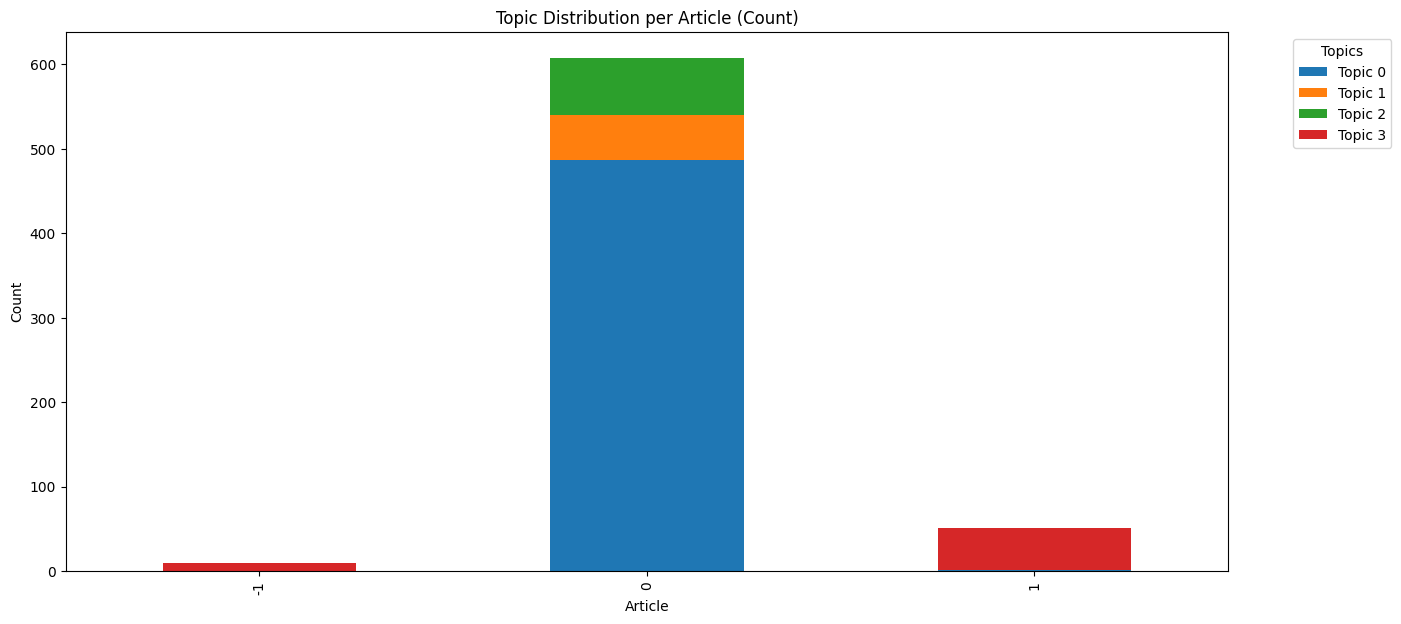

In [32]:
# Calculate the count of times each topic is chosen within each article
article_topic_counts = df_gdpr.groupby('File')['topic_number'].value_counts().unstack(fill_value=0)

# Rename columns to 'Topic X'
article_topic_counts.columns = [f'Topic {i}' for i in article_topic_counts.columns]

# Display the table
print(article_topic_counts)

# Plot the distribution for each article
article_topic_counts.plot(kind='bar', stacked=True, figsize=(15, 7))
plt.title('Topic Distribution per Article (Count)')
plt.xlabel('Article')
plt.ylabel('Count')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

       Topic 0   Topic 1   Topic 2   Topic 3
File                                        
-1    0.000000  0.000000  0.000000  1.000000
 0    0.800987  0.087171  0.111842  0.000000
 1    0.019608  0.000000  0.000000  0.980392


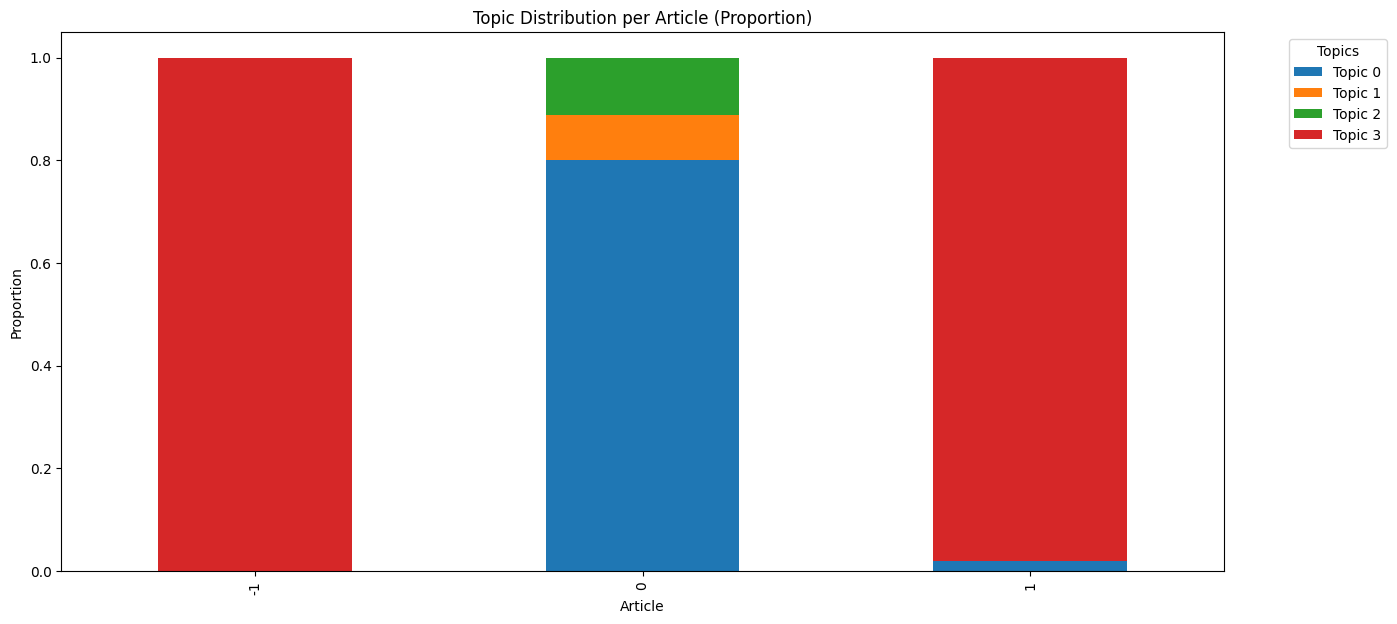

In [33]:

# Calculate the proportion of times each topic is chosen within each article
article_topic_proportions = df_gdpr.groupby('File')['topic_number'].value_counts(normalize=True).unstack(fill_value=0)

# Rename columns to 'Topic X'
article_topic_proportions.columns = [f'Topic {i}' for i in article_topic_proportions.columns]

# Display the table
print(article_topic_proportions)

# Plot the distribution for each article
article_topic_proportions.plot(kind='bar', stacked=True, figsize=(15, 7))
plt.title('Topic Distribution per Article (Proportion)')
plt.xlabel('Article')
plt.ylabel('Proportion')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()